# Setup

In [1]:
import json
import os
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

# Reading and exploring data

In [3]:
# Removing the non-UTF-8 characters present in the CSV file
data = ''

with open(data_path, 'rb') as f:
    for line in f:
        line = line.decode('utf-8', 'ignore')
        data += line

In [4]:
# Reading in as a pandas dataframe
ben_lop2019 = pd.read_csv(StringIO(data))
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [5]:
# Checking basic info
num_species = len(ben_lop2019['Species'].unique())
print(f'{num_species} species')

print(f'{len(ben_lop2019)} effect sizes')

num_studies = len(ben_lop2019['Study'].unique())
print(f'{num_studies} studies')

296 species
3281 effect sizes
163 studies


## Exploring taxonomic representation

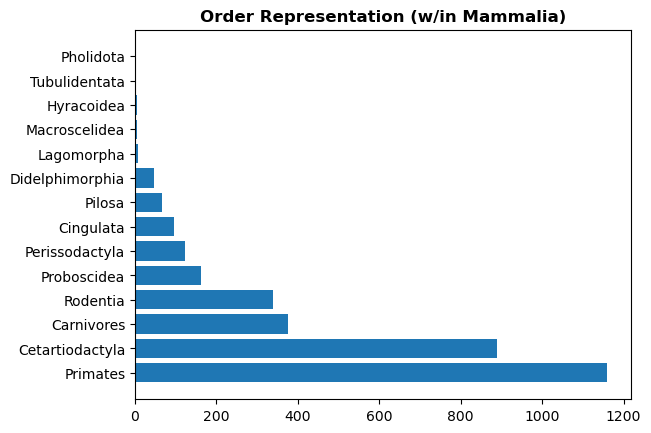

In [6]:
order_counts = ben_lop2019['Order'].value_counts()

plt.barh(order_counts.index, order_counts.values)
plt.title('Order Representation (w/in Mammalia)', weight = 'bold');

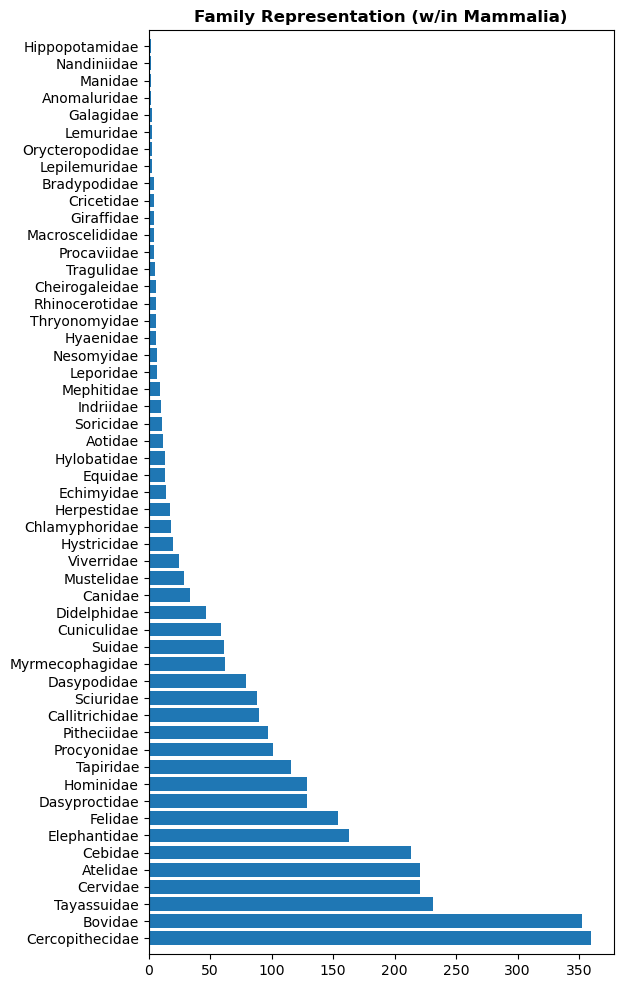

In [7]:
fam_counts = ben_lop2019['Family'].value_counts()

plt.figure(figsize = (6, 12))

plt.barh(fam_counts.index, fam_counts.values)
plt.title('Family Representation (w/in Mammalia)', weight = 'bold')

plt.margins(y = 0.01);

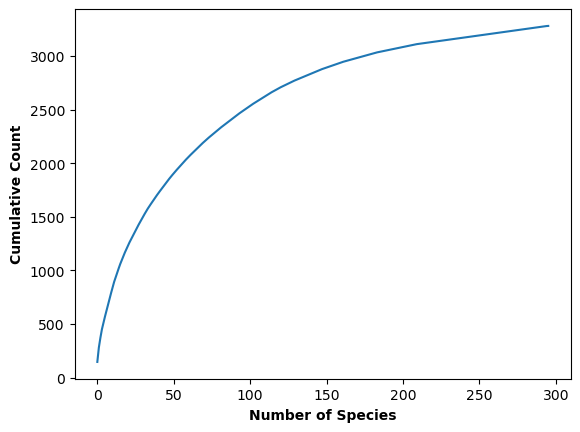

In [8]:
species_counts = ben_lop2019['Species'].value_counts()
species_cumsum = species_counts.to_numpy().cumsum()

plt.plot(species_cumsum)

plt.ylabel('Cumulative Count', weight = 'bold')
plt.xlabel('Number of Species', weight = 'bold');

## Exploring spatial representation

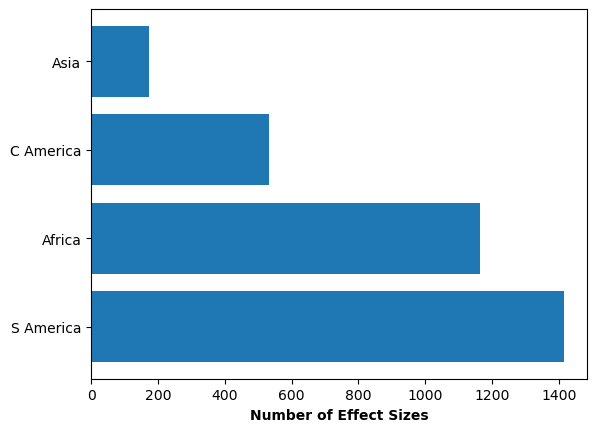

In [21]:
region_counts = ben_lop2019['Region'].value_counts()

plt.barh(region_counts.index, region_counts)
plt.xlabel('Number of Effect Sizes', weight = 'bold');

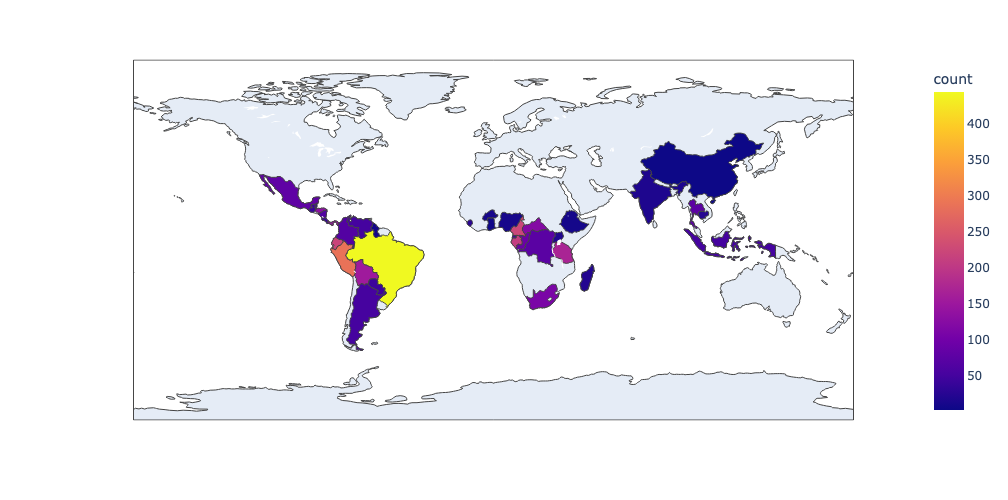

In [20]:
# Plotting distribution of effect sizes across countries
country_counts = ben_lop2019['Country'].value_counts().to_frame().reset_index()

fig = px.choropleth(country_counts, 
                    locations = 'Country',
                    locationmode = 'country names',
                    color = 'count', 
                    hover_name = 'Country', 
                    color_continuous_scale = px.colors.sequential.Plasma, 
                    width = 1000,
                    height = 500)
fig.show()

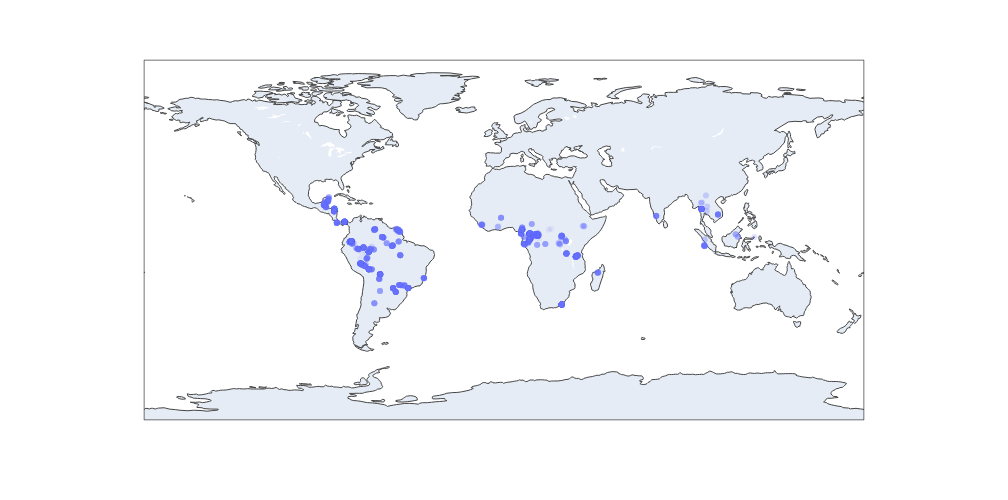

In [140]:
# Plotting study locations as a scatterplot
fig = px.scatter_geo(ben_lop2019, 
                     lat = 'Y',
                     lon = 'X',
                     hover_name = 'Reference',
                     opacity = 0.1,
                     width = 1000,
                     height = 500)
fig.show()

## Inspecting response variable

In [192]:
# Checking number of extirpation events in the dataset
num_non_extirp = (ben_lop2019['ratio'] != 0).sum()
num_extirp = len(ben_lop2019) - num_non_extirp

print(f'{num_extirp} extirpation events ({round(num_extirp / len(ben_lop2019) * 100, 2)}%), {num_non_extirp} non-extirpation events ({round(num_non_extirp / len(ben_lop2019) * 100, 2)}%)')

408 extirpation events (12.44%), 2873 non-extirpation events (87.56%)


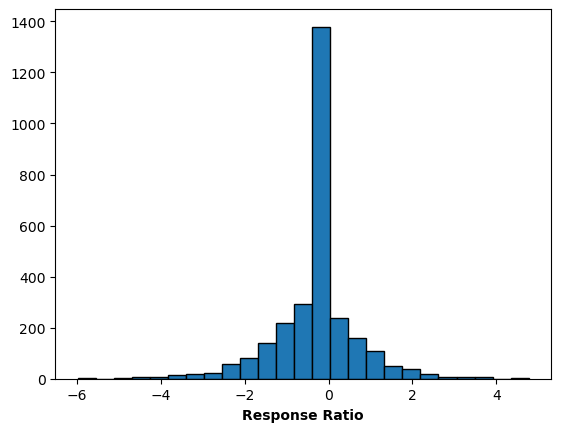

In [155]:
# Plotting a histogram of response ratio
plt.hist(ben_lop2019[ben_lop2019['ratio'] != 0]['RR'], bins = 25, edgecolor = 'black')

plt.xlabel('Response Ratio', weight = 'bold');

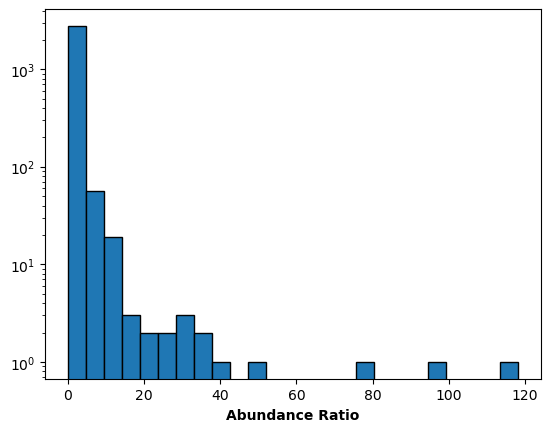

In [154]:
# Plotting a histogram of actual abundance ratios (hunted to unhunted)
plt.hist(ben_lop2019[ben_lop2019['ratio'] != 0]['ratio'], bins = 25, edgecolor = 'black')

plt.yscale('log')
plt.xlabel('Abundance Ratio', weight = 'bold');

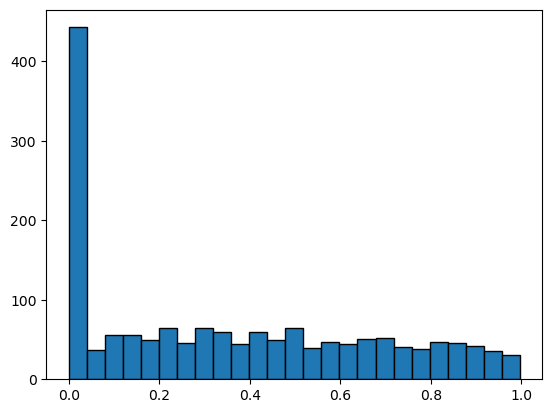

In [158]:
# Plotting thhe distribution of abundance ratios for values between 0 and 1
plt.hist(ben_lop2019[ben_lop2019['ratio'] < 1]['ratio'], bins = 25, edgecolor = 'black');

# Fitting a hurdle model

- Currently, I'm ignoring the random effects component of the model. I think `statsmodels` implements [mixed linear models](https://www.statsmodels.org/stable/mixed_linear.html).
   - [This site](https://geoffruddock.com/building-a-hurdle-regression-estimator-in-scikit-learn/) may be helpful in building an `sklearn` type estimator to fit into a cross-validation procedure.
- Just fitting using the results of their model selection procedure, i.e., only the input variables that they found to be the most important using a [BIC criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion).

**Things currently look weird--the extirpation classifier isn't ever predicting extirpation events and the regression model seems highly skewed, often predicting $RR=-0.2$ for some reason.**

In [103]:
# Prepping the data
rr = ben_lop2019['RR'].copy(deep = True).values
ratio = ben_lop2019['ratio'].copy(deep = True).values
zero_mask = (ben_lop2019['ratio'] != 0).values

#  grabbing needed predictors
X_nonzero = ben_lop2019[['BM', 'DistKm', 'PopDens']].copy(deep = True)
X_zero = ben_lop2019[['BM', 'DistKm', 'PopDens', 'Stunting', 'Reserve']].copy(deep = True)

#  adding cross terms, indicators, and quadratic terms
X_nonzero['DistKm^2'] = X_nonzero['DistKm'] ** 2
X_nonzero['PopDens^2'] = X_nonzero['PopDens'] ** 2
X_nonzero['BMxDistKm'] = X_nonzero['BM'] * X_nonzero['DistKm']

X_zero['DistKm^2'] = X_zero['DistKm'] ** 2
X_zero['Reserve'] = (X_zero['Reserve'] == 'Yes').astype(int)

#  extracting the inputs/outputs for each of the models
X_zero = X_zero.values
y_zero = (ratio == 0).astype(int)

X_nonzero = X_nonzero[zero_mask].copy()
y_nonzero = rr[zero_mask].copy()

In [114]:
# Checking the shapes of predictor and response variables
print(X_zero.shape, y_zero.shape)
print(X_nonzero.shape, y_nonzero.shape)

(3281, 6) (3281,)
(2873, 6) (2873,)


In [115]:
# Defining the two models
nonzero_model = LinearRegression()
zero_model = LogisticRegression(penalty = None)

# Fitting the models to ALL data
nonzero_model.fit(X_nonzero, y_nonzero)
zero_model.fit(X_zero, y_zero);

In [126]:
# Checking predictive accuracy
zero_pred = zero_model.predict(X_zero)
acc = np.mean(zero_pred == y_zero) * 100
print(f'Prob of extirpation model accuracy: {round(acc, 2)}%')

nonzero_pred = nonzero_model.predict(X_nonzero)
nonzero_pred_ratio = np.exp(nonzero_pred)
y_ratio = ben_lop2019['ratio'].values[zero_mask]
med_ae = np.median(np.abs(nonzero_pred_ratio - y_ratio))
print(f'Nonzero RR model median absolute error: {round(med_ae, 2)}')

Prob of extirpation model accuracy: 87.56%
Nonzero RR model median absolute error: 0.25


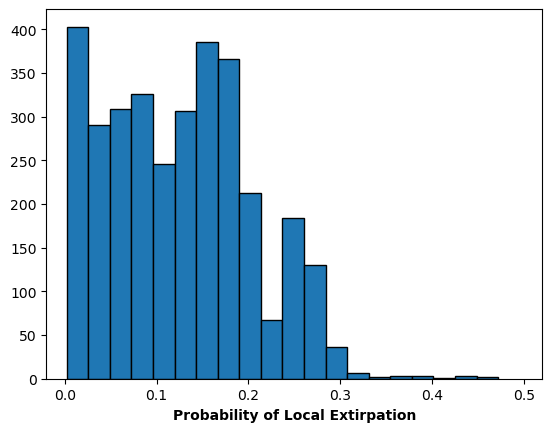

In [185]:
# Taking a look at classification results
plt.hist(zero_model.predict_proba(X_zero)[ : , 1], bins = 20, edgecolor = 'black')

plt.xlim(-0.02, 0.52)
plt.xlabel('Probability of Local Extirpation', weight = 'bold');

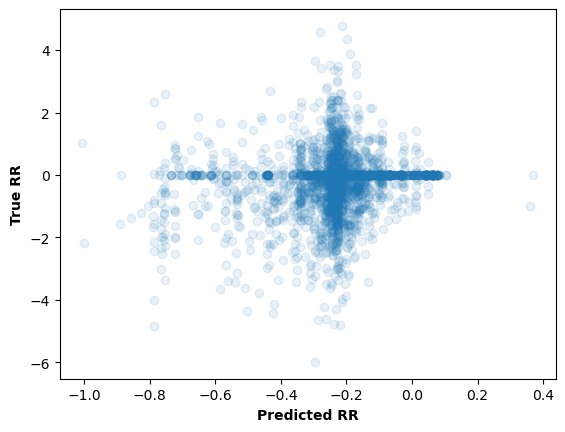

In [136]:
# Regression results, RR
plt.scatter(nonzero_pred, y_nonzero, alpha = 0.1)

plt.xlabel('Predicted RR', weight = 'bold')
plt.ylabel('True RR', weight = 'bold');

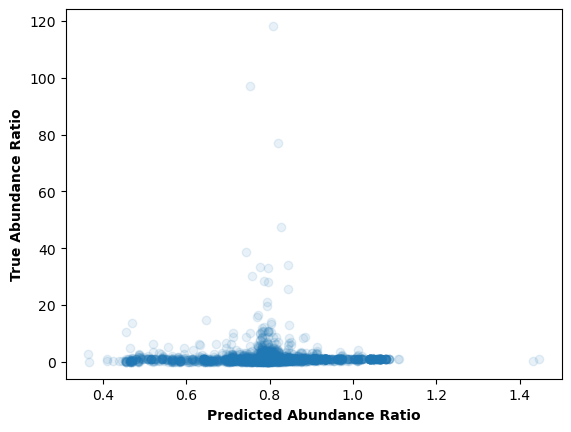

In [200]:
# Regression results, abundance ratio
plt.scatter(nonzero_pred_ratio, y_ratio, alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');